# More trajectory optimisation and quadratic programming
In this tutorial we will continue working with convex optimisation tools for trajectory optimisation. Later in the tutorial, we will use a more common approach than Euler integration to compute trajectory, which consists in using a polynomial to describe the trajectory of a system. 

But first, we will consider the problem setup of tutorial 4, but we will take a different approach to solving the problem, by directly trying to describe $\mathcal{C}_{free}$. We will use what we call a convex conver of the configuration space, an approximation of the configuration space to plan optimal trajectories.

## Part 1: Convex cover and motion planning
### Convex cover


Let's reload tutorial 4:


In [1]:
import magic_donotload
import pinocchio as pin #the pinocchio library
from utils.meshcat_viewer_wrapper import MeshcatVisualizer # the meshcat visualiser
from utils.load_ur5_with_obstacles import load_ur5_with_obstacles_rrt # helper function to load scene
from scipy.optimize import fmin_bfgs,fmin_slsqp # some optimisation routines from scipy
import time # the remaining libraries are python native
import numpy as np 
from numpy.linalg import norm
import matplotlib.pylab as plt 

robot = load_ur5_with_obstacles_rrt(reduced=True)

viz = MeshcatVisualizer(robot)
viz.display(robot.q0)


NB: as for all the tutorials, a magic command %do_not_load is introduced to hide the solutions to some questions. Change it for %load if you want to see (and execute) the solution.
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Let us visualise again the plot showing the 2D configuration space. The sampled points have been stored in a file to avoid recomputing this.

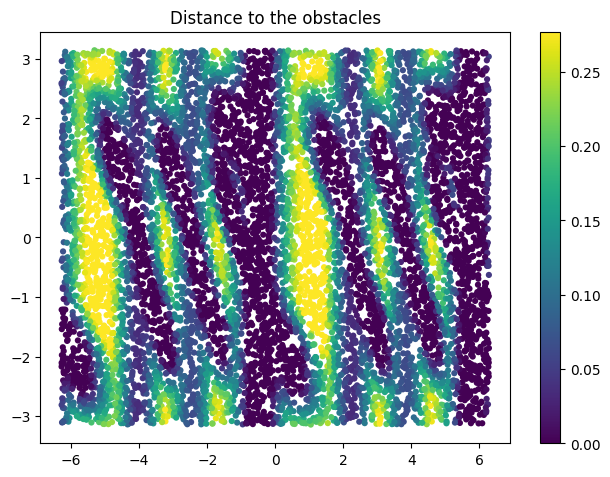

In [2]:
distance_data = np.load("./tp7/distance_data.npy")

def plotConfigurationSpace(data,markerSize=20):
     plt.subplot(1,1,1)
     plt.scatter(data[:,0],data[:,1],c=data[:,2],s=markerSize,lw=0)
     plt.title("Distance to the obstacles")
     plt.colorbar()
     plt.tight_layout(pad=0.8)

plotConfigurationSpace(distance_data)

What we are going to do now is to try to approximate  $\mathcal{C}_{free}$ with a union of polygons.
The code belows defines polygons of interest for our problem. If you are interested in generating them by yourselves,
you can take a look that this paper: https://ieeexplore.ieee.org/document/1570649 .

We will also create a start and goal position for our motion planning problem.

The following code uses the `ConvexHull` class from the scipy package. It is a really useful library to work with polygons.
In particular, it can directly give us the inequalities that we will use to verify whether a point belongs to a polygons.

#### Note:
The generalisation of a polygon to an arbitrary dimension is called a polytope. We will use this terminology in the remainder of the tutorial.


Let us assume that the relevant portion of $\mathcal{C}_{free}$ is covered by 4 polytopes  $\mathcal{P}_i : \{\mathbf{x} \in \mathbb{R}^2, \mathbf{A}_i  \mathbf{x} \leq \mathbf{b}_i\}, i \in [1,2,3,4]$, with  that  matrix  $\mathbf{A}_i $ and vector  $\mathbf{b}_i$ known.


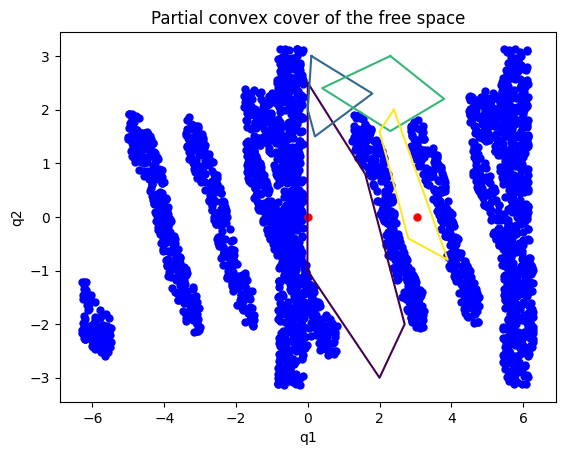

In [3]:


#initial and goal position
q_init = robot.q0.copy()
q_goal = np.array([3.05429572, 0.20489405])

from scipy.spatial import ConvexHull


hull1 = ConvexHull(np.array([[-0.01,-1.], [2,-3], [2.7,-2], [1.6,0.8], [0,2.5]]))
hull2 = ConvexHull(np.array([[0.2,1.5], [0,2], [0.1, 3], [1.8, 2.3], ]))
hull3 = ConvexHull(np.array([[0.4,2.4], [2.3,1.6], [3.8, 2.2] , [2.3, 3] ]))
hull4 = ConvexHull(np.array([[2.8,-0.4], [2.,1.6],  [2.4, 2], [3.9,-0.8], ]))
hulls = [hull1, hull2, hull3, hull4]


#let us plot the polytopes to check that they look "okay"
def plot_hull_and_points(hulls, collision_samples, q_init, q_goal):
    """
    Plots each each polytope in hulls with a unique color.
    
    Parameters:
    - hulls: list of ConvexHull objects
    - collision_samples: list of samples to be displayed
    - q_init: initial configuration
    - q_goal: goal configuration
    """
    plt.figure()
    data = np.array(collision_samples)
    plt.scatter(data[:,0],data[:,1],c="blue",lw=0)
    plt.scatter(q_init[0],q_init[1],c="red",lw=0)
    plt.scatter(q_goal[0],q_init[1],c="red",lw=0)
    # Use a color map to assign a unique color to each kernel
    colors = plt.cm.viridis(np.linspace(0, 1, len(hulls)))
    for (hull, color) in zip (hulls, colors):
        hull_points = hull.points[hull.vertices]
        # Close the hull by appending the first point at the end
        hull_points = np.append(hull_points, [hull_points[0]], axis=0)
        plt.plot(hull_points[:, 0], hull_points[:, 1], color=color)
    plt.xlabel("q1")
    plt.ylabel("q2")
    plt.title("Partial convex cover of the free space")
    plt.show()

#recolting samples in collision to check our polytopes do not include them
collision_samples = [ np.array([sample[0], sample[1]]) for sample in distance_data if sample[2]  < 1e-6]
plot_hull_and_points(hulls, collision_samples, q_init, q_goal)


We assume that the polytopes are sorted in the order in which they need to be traversed. This means that the intial configuration must be included in the first polytope, while the second one is included in the last polytope. Let us check this formally

In [4]:
def hull_ineq(hull):
    """
    Extracts the inequality representation of a convex hull.

    Given a convex hull from `scipy.spatial.ConvexHull`, this function 
    returns a matrix `A` and vector `b` such that for any point `x` inside 
    or on the hull, the inequality `A @ x <= b` holds true.

    Parameters:
    -----------
    hull : scipy.spatial.ConvexHull
        A ConvexHull object representing the convex hull of a set of points.

    Returns:
    --------
    A : numpy.ndarray
        A 2D array where each row corresponds to the coefficients of 
        an inequality that defines one facet of the convex hull.
        
    b : numpy.ndarray
        A 1D array where each element is the intercept term of the 
        corresponding inequality from `A`, adjusted to satisfy the 
        inequality `A @ x <= b`.
    """
    A =  hull.equations[:, :-1]    
    b = -hull.equations[:, -1]
    return A, b


A0, b0 =  hull_ineq(hulls[0])
assert((A0.dot(q_init) < b0).all())


A3, b3 =  hull_ineq(hulls[-1])
assert((A3.dot(q_goal) < b3).all())

#We can also check our polytopes do not include any colliding samples
for i, hull in enumerate(hulls):
    A, b = hull_ineq(hull)
    res = [sample for sample in collision_samples if np.all(A.dot(sample) - b < 1e-6)]
    if len(res) > 0:
        print ("hull " + str(i) + "contains collisions")

### Is our problem feasible ? A first path computation

(for an introduction to quadprog take a look [here](https://scaron.info/blog/quadratic-programming-in-python.html) )

Our planning problem, given the sequence of polytopes, is reformulated as the computation of a path that, at any stage of the path, is included in one of the polytope. For now, let us just consider geometric constraints and ignore the dynamics of our robot.

If we assume that $\mathcal{C}_{free}$ is correctly approximated by our polytopes $\mathcal{P}_i$, then for a solution to exist we must have $\mathcal{P}_i \cap \mathcal{P}_{i+1} \ne \emptyset$, $\forall i \in [1,2,3]$.

To verify whether this is the case, we can simply check that we can find a point inside each intersection. As all our polytopes are convex, we can show that the intersection of 2 polytopes can be obtained simply by stacking their respective inequalities. As a result, we can simply wrote and solve the following LP:

<center><img src="./tp7/feas.png"/ width="380"></center>


Simple enough!
Let's write this:


In [5]:
#first let's collect the inequalities associated with each polytope:
Ab_is = [hull_ineq(hull) for hull in hulls]

n_cols = 6 #we have 6 variables in our problem, since each x^[i,i+1} is in R2
A = np.empty((0, n_cols)) 
b = np.empty((0)) #our inequality matrix has 6 colums

#I ll just make two loops for simplicity of reading
# first loop deals with A_i x^{i, i+1} <= b_i
for i, (Ai, bi) in enumerate(Ab_is[:-1]): 
    Ai_all = np.zeros((Ai.shape[0],n_cols) )
    Ai_all[:, i*2:i*2+2] = Ai #we need to copy the inequality on the right colums of the matrix
    A = np.vstack([A, Ai_all])    
    b = np.hstack([b, bi])


# second loop deals with A_{i+1} x^{i, i+1} <= b_{i+1}.
# let's set j = i+1
for i, (Aj, bj) in enumerate(Ab_is[1:]): 
    j = i+1
    Aj_all = np.zeros((Aj.shape[0],n_cols))
    Aj_all[:, i*2:i*2+2] = Aj #we need to copy the inequality on the right colums of the matrix
    A = np.vstack([A, Aj_all])    
    b = np.hstack([b, bj])

#now optimise
from scipy.optimize import linprog
l = np.zeros(n_cols) #no cost fuction, this is a feasibility problem
res = linprog(l, A_ub=A, b_ub=b )
print (res.success)
    

True


The optimisation was successful. Interestingly, the result of this optimisation actually gives us a feasible path already. Since all the polytopes are convex, the polyline $\mathbf{q}_{init} \rightarrow \mathbf{x}^{1,2} \rightarrow \mathbf{x}^{2,3} \rightarrow \mathbf{x}^{3,4} \rightarrow \mathbf{q}_{goal}$ is guaranteed to be on collision free, since each line of the path stays entirely within its associated polytope. let us plot this to verify

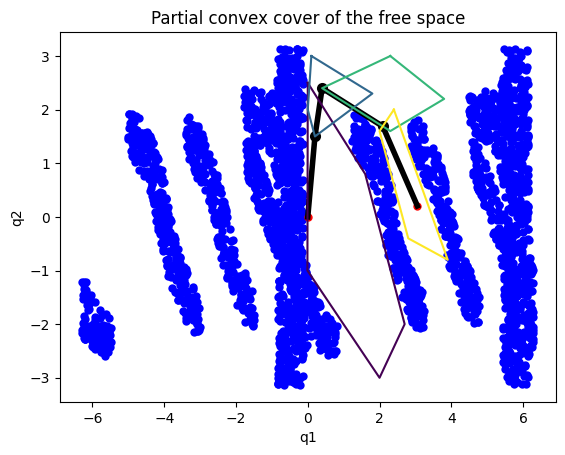

In [6]:
#let us plot the polytopes to check that they look "okay"
def plot_hull_and_path(hulls, collision_samples, q_init, q_goal, x):
    """
    Plots each each polytope in hulls with a unique color.
    
    Parameters:
    - hulls: list of ConvexHull objects
    - collision_samples: list of samples to be displayed
    - q_init: initial configuration
    - q_goal: goal configuration
    - x: a 6d vector, the result of the LP problem we have just solved
    """
    plt.figure()
    data = np.array(collision_samples)
    plt.scatter(data[:,0],data[:,1],c="blue",lw=0)
    plt.scatter(q_init[0],q_init[1],c="red",lw=0)
    plt.scatter(q_goal[0],q_goal[1],c="red",lw=0)

    # Extract the 2D points from x
    x_points = x.reshape(3, 2)  # Convert the 6D vector into 3 points of 2D each

    # Plot polyline from q_init to each point in x and then to q_goal
    path_points = np.vstack([q_init, x_points, q_goal])
    plt.plot(path_points[:, 0], path_points[:, 1], color="black", linewidth=4, label="Path")
    plt.scatter(x_points[:,0],x_points[:,1],c="black",lw=2)
    
    # Use a color map to assign a unique color to each kernel
    colors = plt.cm.viridis(np.linspace(0, 1, len(hulls)))
    for (hull, color) in zip (hulls, colors):
        hull_points = hull.points[hull.vertices]
        # Close the hull by appending the first point at the end
        hull_points = np.append(hull_points, [hull_points[0]], axis=0)
        plt.plot(hull_points[:, 0], hull_points[:, 1], color=color)
    plt.xlabel("q1")
    plt.ylabel("q2")
    plt.title("Partial convex cover of the free space")
    plt.show()


plot_hull_and_path(hulls, collision_samples, q_init, q_goal, res.x)

Let us display that path on meshcat, reusing the code from  tutorial 4:

In [7]:
from math import ceil
from time import sleep

path = [q_init] + [ el for el in res.x.reshape(3,2)] + [q_goal]

def distance(q1,q2):    
    '''Return the euclidian distance between two configurations'''
    return np.linalg.norm(q2-q1)

def lerp(q0,q1,t):    
    return q0 * (1 - t) + q1 * t


def displayedge(q0,q1,vel=2.): #vel in sec.    
    '''Display the path obtained by linear interpolation of q0 to q1 at constant velocity vel'''
    dist = distance(q0,q1)
    duration = dist / vel    
    nframes = ceil(48. * duration)
    f = 1./48.
    for i in range(nframes-1):
        viz.display(lerp(q0,q1,float(i)/nframes))
        sleep(f)
    viz.display(q1)
    sleep(f)
    
def displaypath(path):
    for q0, q1 in zip(path[:-1],path[1:]):
        displayedge(q0,q1)
    
displaypath(path)

### A minimum distance path in the configuration space
Rather than simply finding a feasible path, we now want a path such that the distance traveled is minimal in the configuration space.
To do this, we simply need to minimise the sum of the distance traveled by each polyline. If we write $\mathbf{q}_{init} = \mathbf{x}^{0,1}$ and $\mathbf{q}_{goal} = \mathbf{x}^{4,5}$ the quadratic programme corresponding is: 

<center><img src="./tp7/min_dist_qp.png"/ width="380"></center>





This problem is in linear least squares form. Denoting each term in the sum function by $ \|\mathbf{C}\mathbf{x} - \mathbf{c}\|_2^2 $, we can convert it to QP form as follows:

\begin{aligned}
\|\mathbf{C}\mathbf{x} - \mathbf{c}\|_2^2  & = (\mathbf{C}\mathbf{x} - \mathbf{c})^T (\mathbf{C}\mathbf{x} - \mathbf{c}) \\
& = \mathbf{x}^T \mathbf{C}^T \mathbf{C} \mathbf{x} - \mathbf{x}^T \mathbf{C}^T \mathbf{c} - \mathbf{c}^T \mathbf{C} \mathbf{x} + \mathbf{c}^T \mathbf{c} \\
& \propto \frac{1}{2} \mathbf{x}^T \mathbf{C}^T \mathbf{C} \mathbf{x} - \frac{1}{2} \mathbf{x}^T \mathbf{C}^T \mathbf{c} - \frac{1}{2} \mathbf{c}^T \mathbf{C} \mathbf{x}\\
& = \frac{1}{2} \mathbf{x}^T (\mathbf{C}^T \mathbf{C}) \mathbf{x} + (-\mathbf{C}^T \mathbf{c})^T \mathbf{x}
\end{aligned}

The constant offset $ \mathbf{c}^T \mathbf{c} $ does not affect $ \mathbf{x}^* $, therefore we can leave it out. Meanwhile, $ \mathbf{y}^T = \mathbf{y} $ for any real number $ \mathbf{y} $, therefore $ \mathbf{x}^T \mathbf{C}^T \mathbf{c} = \mathbf{c}^T \mathbf{C} \mathbf{x} $ and we can combine the two middle terms into a single $ \mathbf{q} = -\mathbf{C}^T \mathbf{c} $. In Python, we then write:



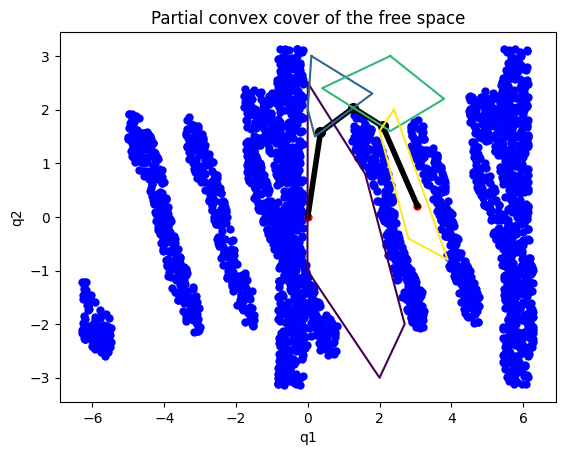

In [9]:
# quadratic form of 0.5 * ||C x - c||^2
def to_quadratic_form(C, c):
    return 0.5 * C.T @ C, - C.T @ c

# Example: 4 waypoints, 2D each → n_cols = 8
cs = [q_init] + [np.zeros(2) for _ in range(3)] + [q_goal]  # 5 elements total
Cs = []

# anchor initial
C = np.zeros((2, n_cols))
C[0, 0] = 1
C[1, 1] = 1
Cs.append(C)

# differences between consecutive points
num_segments = (n_cols // 2) - 1
for i in range(num_segments):
    C = np.zeros((2, n_cols))
    C[0, (i+1)*2  ] =  1
    C[1, (i+1)*2+1] =  1
    C[0, (i)*2    ] = -1
    C[1, (i)*2+1  ] = -1
    Cs.append(C)

# anchor goal
C = np.zeros((2, n_cols))
C[0, n_cols-2] = -1
C[1, n_cols-1] = -1
Cs.append(C)

# combine
hessians = [to_quadratic_form(C, c) for (C, c) in zip(Cs, cs)]
H, l = map(sum, zip(*hessians))


#time to solve our QP
import quadprog


def quadprog_solve_qp(H, q, G=None, h=None, C=None, d=None, verbose=False):
    """
    min (1/2)x' P x + q' x
    subject to  G x <= h
    subject to  C x  = d
    """
    qp_G = 0.5 * (H + H.T)  # make sure P is symmetric
    qp_a = -q
    qp_C = None
    qp_b = None
    meq = 0
    if C is not None:
        if G is not None:
            qp_C = -np.vstack([C, G]).T
            qp_b = -np.hstack([d, h])
        else:
            qp_C = -C.transpose()
            qp_b = -d
        meq = C.shape[0]
    elif G is not None:  # no equality constraint
        qp_C = -G.T
        qp_b = -h
    res = quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)
    if verbose:
        return res
    return res[0]

x = quadprog_solve_qp(H, l, A, b)


plot_hull_and_path(hulls, collision_samples, q_init, q_goal, x)

It really looks that the first 2 lines could be replaced by a straight line for a shorter path! However, given the constraints of our problem, this path is considered invalid. Thus, our **approximation prevents us from finding a truly optimal solution**! This is a very common issue with approximations, and often this means that we can't find the true optimum for our problem.

Let's see what we obtain as a path in meshcat

In [10]:
shortpath = [q_init] + [ el for el in x.reshape(3,2)] + [q_goal]
displaypath(shortpath)

Removing the first waypoint, we can a 'more' optimal path for our problem:

In [11]:
shortestpath = [q_init] + [ el for el in x.reshape(3,2)[1:]] + [q_goal]
displaypath(shortestpath)

## Part 2: trajectory optimisation
Let us forget about collisions for the moment, and formulate an trajectory optimisation problem in a much simpler setup. This time we will work with the complete UR5 model, with 6 DOFs.

The problem formulation here solves a very trivial problem. The idea is for you to get familiar with the approach before coming back to our original problem.


In [12]:
from utils.load_ur5_with_obstacles import load_ur5_with_obstacles,Target # helper function to load scene

robot = load_ur5_with_obstacles(reduced=False, obstacles = False)
viz = MeshcatVisualizer(robot)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


Let us define two configurations start and goal, and find a trajectory between both such that
* the trajectory is continuous and differentiable
* the joint limits are respected

In [13]:
q_start = np.array([-0.62831853, -0.62831853, -0.31415927, -0.62831853, -0.62831853, -0.62831853])

q_end = - q_start
viz.display(q_start)

#defining arbitrary joint limits on the robot
robot.model.lowerPositionLimit = q_start.copy()
robot.model.upperPositionLimit = q_end.copy()




### Setting up the trajectory formulation


We will formulate our optimisation problem using a single degree 3 polynomial to represent our trajectory.
We could use a variety of curves to represent this, each with its specific pros and cons.
In this example we will use a hermite cubic spline that has the following formulation on a [0,1] interval:

$$ \boldsymbol{p}(t) = \left(2t^3 - 3t^2 + 1\right) \boldsymbol{p}_0 + \left(t^3 - 2t^2 + t\right) \boldsymbol{m}_0 + \left(-2t^3 + 3t^2\right) \boldsymbol{p}_1 + \left(t^3 - t^2\right) \boldsymbol{m}_1 $$

where $\boldsymbol{p}_0 $ and $\boldsymbol{p}_1$ are the initial and final control points and $\boldsymbol{m}_0 $ and $\boldsymbol{m}_1$ are the starting and ending tangent (ie velocity).

We can observe that if t is fixed the expression of the polynomial is linear in the control variables $\boldsymbol{m}_i $ and $\boldsymbol{p}_i$. 

With this formulation we can see that in our case the $\boldsymbol{p}_i$ are constant, and only the initial velocities are variables of our problem. Indeed $\boldsymbol{p}_0 = q_{start}$ and $\boldsymbol{p}_1 = q_{end}$ .

This also gives us the dimension of our control points, ie 6.
As a result, we have 12 variables to consider in our optimisation problem, 6 for $\boldsymbol{m}_0 $ and 6 more for $\boldsymbol{m}_1$.

### discretising the curve
To verify our constraints, we decide to only verify that they are satisfied at discrete points along the trajectory.
For instance, we can decide to discretise the trajectory into N points. Each of these points only depends on the control points of the spline, since t is fixed. This will thus give us a linear expression of any point as a function of $\boldsymbol{m}_0 $ and $\boldsymbol{m}_1 $, which we can write in matrix form:

$$ \boldsymbol{p}_{i} = \underbrace{\left(t_i^3 - 2_i^2 + t_i\right)}_{\boldsymbol{d}_i} \boldsymbol{m}_0 +  \underbrace{\left(t_i^3 - t_i^2\right)}_{\boldsymbol{e}_i} \boldsymbol{m}_1 + \underbrace{\left(2t_i^3 - 3t_i^2 + 1\right) \boldsymbol{p}_0 + \left(-2t_i^3 + 3t_i^2\right) \boldsymbol{p}_1}_{\boldsymbol{b}_i}$$

defining $\mathbf{x} = [\mathbf{m}_0; \mathbf{m}_1]^T $ we can then write in matrix form:

$$ \boldsymbol{p}_{i} = diag(\underbrace{\begin{bmatrix}
\mathbf{d}_i & \mathbf{d}_i &\mathbf{d}_i & \boldsymbol{e}_i  & \boldsymbol{e}_i & \boldsymbol{e}_i
\end{bmatrix}}_{\mathbf{A}_i}) \boldsymbol{x}+ \boldsymbol{b}_i $$

Let us write the function that computes the matrices $\mathbf{A}_i$ and $\mathbf{b}_i$:


In [14]:
def pi(p0, p1, ti):
    ti2 = ti *ti
    ti3 = ti2*ti
    di = ti3 - 2* ti2 + ti
    ei = ti3 - ti2
    bi = (2*ti3 - 3* ti2 + 1) * p0 + (3*ti2 - 2*ti3) * p1
    Ai = np.diag(np.array([di,di,di,ei,ei,ei]))
    return (Ai, bi)


## Dealing with joint constraints

To find a trajectory that respects joint limits, we will check that all discretised point satisfy joint limits.
For each $\mathbf{p}_i$, we need to verify that $\mathbf{p}_i \leq \mathbf{q}^+$ and $\mathbf{q}^- \leq \mathbf{p}_i$.

This means that we must verify 

$$\mathbf{A}_i \mathbf{x} + \mathbf{b}_i \leq \mathbf{q}^+ $$, ie 
$$\mathbf{A}_i \mathbf{x} \leq \mathbf{q}^+ - \mathbf{b}_i  $$

Similarly we write
$$\mathbf{A}_i \mathbf{x} + \mathbf{b}_i \geq \mathbf{q}^-$$, which gives

$$\mathbf{b}_i - \mathbf{q}^- \geq -\mathbf{A}_i \mathbf{x} $$

Getting q_min and q_max is easy:

In [15]:
qmax =  robot.model.upperPositionLimit
qmin =  robot.model.lowerPositionLimit
nsteps = 48 # check constraints 48 times between start and end

We can thus easily define the matrix inequality to satisfy joint limits at position i:

In [16]:
def jointlimitconstraint(p0, p1, ti):
    (Ai, bi) = pi(p0, p1, ti)
    bmin = bi - qmin
    Amin = -Ai
    bmax = qmax - bi
    Amax = Ai.copy()
    #now stacking the constraints
    A = np.vstack([Amin,Amax])
    b = np.concatenate((bmin,bmax))
    return (A,b)

A0, b0 = jointlimitconstraint(q_start, q_end, 0.5)

We can now stack all constraints into one big matrix and vector that will give us the inequalities for all discrete points and solve our feasibility problem. 

In [17]:
A = np.zeros((0,6))#empty matrix
b = np.zeros(0) #empty vector

for i in range(1, nsteps):
    ti = 1. / nsteps * i
    Ai, bi = jointlimitconstraint(q_start, q_end, ti)
    A = np.vstack([A,Ai])
    b = np.concatenate((b,bi))
   
#solves a feasibility qp given a constraint matrix A <= b 
def solve_lp_feasibility(A,b):
    #create a simple cost as we are only looking for a feasible solution for now
    l = np.zeros(6)
    res = linprog(l, A_ub=A, b_ub=b )
    return res.x

res = solve_lp_feasibility(A,b)


def plot_from_res(x):
    for i in range(1000):
        Ai, bi = pi(q_start, q_end, 1./1000*i)
        p = Ai.dot(x) + bi
        viz.display(p)

plot_from_res(res)

The solution we obtained is such that m0 and m1 are zeros. You can write the code that computes the corresponding curve and displays it to verify that this corresponds to the linear interpolation. So apparently these constraints were not useful!  Indeed our problem was very simple in this case.

## Part 3: Polynomial optimisation for motion planning
Go back to the motion planning problem and write a trajectory optimisation problem that will compute a collision free trajectory, expressed as a polynomial, from the start to the goal. You have several options available for this. You can either write optimise several polynomials (one for each polytopes) and write continuity constraints between them.

I would rather advise to optimise for a single polynomial that goes over across all polytopes. Choose a fixed duration and impose arbitrary times when the polynomial switches from one polytope to the next one. This should let you write the constraints easily.

I would also suggest solving this iteratively:
+ first place the goal in the same polytope as the starting configuration (no need to switch between polytopes when writing the constraints);
+ then place the goal in the next polytope and check that you compute a trajectory that satisfies your constraints;
+ finally, try to solve the complete problem.

If your problem becomes unfeasible, it may be because the degree of the chosen polynomial is not high enough to allow for complex motions. You might need to rewrite the constraints for a larger polynomial.

If you want to play more with the concepts, consider adding additional constraints on velocity and acceleration. They can be derived by computing the derivative of the polynomial you consider and expressing the values of the derivatives at each time step as for the position.

